In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import plotly.express as px
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from statsmodels.nonparametric.smoothers_lowess import lowess


from imports import get_comp
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_rows', 20)

cmap = {'APU': '#C7253D', 'AMU': '#53B2FF', 'APR': '#193E2E'}
cmap_grey = {'APU': '#E98695', 'AMU': '#5CB6FF', 'APR': '#40A075'}

In [8]:
comp = get_comp()
comp_APU = comp[comp["TIPAU"] == "APU"]
comp_AMU = comp[comp["TIPAU"] == "AMU"]
comp_APR = comp[comp["TIPAU"] == "APR"]
comp_1000 = comp[comp["TOTAL_INE_21"] >= 1000]

In [9]:
comp.head()

,TIPAU,Distrito,CC_DSG,FF_DSG,PT_INE_21,TOTAL_INE_21,PT_INE_11,TOTAL_INE_11,PT_INE_01,TOTAL_INE_01,...,PT_MAI_21,PT_MAI_11,PT_MAI_01,diff_abs_21,diff_abs_11,diff_abs_01,diff_rel_21,diff_rel_11,diff_rel_01,VAR_diff_rel_21_11
FREGUESIA,,,,,,,,,,,,,,,,,,,,,
160102,APU,Viana do Castelo,Arcos de Valdevez,AGUIÃ,615,622,587,592,571,573,...,801.00,871,692,186.00,284,121,30.20,48.40,21.20,-18.20
160124,APU,Viana do Castelo,Arcos de Valdevez,PAÇÔ,814,834,754,770,654,660,...,"1,031.00",1044,720,217.00,290,66,26.70,38.50,10.10,-11.80
160153,APU,Viana do Castelo,Arcos de Valdevez,UNIÃO DAS FREGUESIAS DE ARCOS DE VALDEVEZ (SÃO...,1362,1405,1300,1353,1313,1322,...,"1,711.00",1826,1545,349.00,526,232,25.60,40.50,17.70,-14.90
160154,APU,Viana do Castelo,Arcos de Valdevez,UNIÃO DAS FREGUESIAS DE ARCOS DE VALDEVEZ (SÃO...,2215,2315,2018,2075,1699,1716,...,"2,704.00",2459,1852,489.00,441,153,22.10,21.90,9.00,0.20
160157,APU,Viana do Castelo,Arcos de Valdevez,UNIÃO DAS FREGUESIAS DE GUILHADESES E SANTAR,972,988,1030,1035,893,905,...,"1,190.00",1173,1015,218.00,143,122,22.40,13.90,13.70,8.50


In [ ]:
evolution = comp_1000[['diff_rel_01', 'diff_rel_11', 'diff_rel_21', 'TIPAU']]
evolution = evolution[(evolution["TIPAU"] != "APR") & (evolution["TIPAU"] != "AMU")]

# Generate the plot
plt.figure(figsize=(10, 6))  # Set the figure size

for category, color in cmap.items():
    df_category = evolution[evolution['TIPAU'] == category].drop('TIPAU', axis=1)
    df_category.T.plot(marker='o', color=color)
    
plt.xlabel('Year')  # Set the x-axis label
plt.ylabel('Population')  # Set the y-axis label
plt.title('Population Evolution')  # Set the plot title
plt.grid(True)  # Add grid lines
plt.show()  # Display the plot

In [ ]:
#fig = px.scatter(comp_APU, x='PT_INE_21', y='diff_rel_21', hover_data=['FF_DSG', "PT_MAI_21"])

# Create the scatterplot
fig, ax = plt.subplots()
ax.scatter(comp['diff_rel_21'], comp['PT_INE_21'], c=comp['TIPAU'].map(cmap), s=5)
ax.set_xlabel('diff_rel')
ax.set_ylabel('População (INE)')

plt.show()

# Show the plot
fig.show()

In [ ]:
plt.figure(figsize=(5, 6))

ax1 = plt.subplot(2, 1, 1)
scatter1 = plt.scatter(comp['sec+_INE_21'], comp['diff_rel_21'], c=comp['TIPAU'].map(cmap), s=2)
plt.ylabel('Erro Relativo (%)')

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
scatter2 = plt.scatter(comp_1000['sec+_INE_21'], comp_1000['diff_rel_21'], c=comp_1000["TIPAU"].map(cmap), s=2)
plt.xlabel('Ensino Secundário Completo (%)')
plt.ylabel('Erro Relativo (%)\n >1000 habitantes')

plt.show()


In [ ]:
fig = px.scatter(comp, x='sec+_INE_21', y='diff_rel_21',
                                  labels={
                     "diff_rel_21": "Erro Relativo (%)",
                     "sec+_INE_21": "Ensino Secundário Completo (%)"
                 }, color='TIPAU', color_discrete_map=cmap, hover_data=['FF_DSG', "PT_INE_21", "PT_MAI_21"])

# Show the plot
fig.show()

In [167]:
scaler = MinMaxScaler(feature_range=(1, 40))  # Adjust the feature range as needed
pt_ine_21_scaled = scaler.fit_transform(comp['PT_INE_21'].values.reshape(-1, 1)).flatten()

# Set the size parameter to 'log_PT_INE_21' in px.scatter
fig = px.scatter(comp, x='sec+_INE_21', y='diff_rel_21',
                 labels={
                     "diff_rel_21": "Erro Relativo (%)",
                     "sec+_INE_21": "Ensino Secundário Completo (%)"
                 },
                 color='TIPAU', color_discrete_map=cmap,
                 size=pt_ine_21_scaled,
                 size_max=40,
                 hover_data=['FF_DSG', "PT_INE_21", "PT_MAI_21"])


# Show the plot
fig.show()

In [210]:
import colorsys
import copy

def lighten_color(color_hex, factor):
    rgb = mcolors.hex2color(color_hex)
    h, s, v = colorsys.rgb_to_hsv(*rgb)
    v = min(1, v + factor)
    rgb = colorsys.hsv_to_rgb(h, s, v)
    return mcolors.rgb2hex(rgb)

def sorting_key(interval):
    return interval[0]  # Use the first element of the interval as the sorting key


def print_scatter(variableX, variableY, variableZ, variableXtitle, variableYtitle, name="test.html", division="TIPAU", nbins = 5, frac=0.3):
    
    if division == "TIPAU":
        # Group the data and calculate conditional means
        grouped_data_APR = comp_APR.groupby(variableX)[variableY].mean().reset_index()
        grouped_data_APU = comp_APU.groupby(variableX)[variableY].mean().reset_index()
        grouped_data_AMU = comp_AMU.groupby(variableX)[variableY].mean().reset_index()
        # Apply LOESS smoothing to the grouped data
        smoothed_data_APR = lowess(grouped_data_APR[variableY], grouped_data_APR[variableX], frac=frac)
        smoothed_data_APU = lowess(grouped_data_APU[variableY], grouped_data_APU[variableX], frac=frac)
        smoothed_data_AMU = lowess(grouped_data_AMU[variableY], grouped_data_AMU[variableX], frac=frac)
    elif division == "population":
        comp["Tamanho"], cut_bin = pd.qcut(comp['PT_INE_21'], q = nbins, retbins = True)
        
        cmap_pop = sns.color_palette("rocket_r",n_colors=nbins)
   
        comp["Tamanho"] = comp["Tamanho"].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))
        labels = comp["Tamanho"].unique()
        labels = labels.to_list()
        labels = labels[-1:] + labels[:-1]
        cmap_pop_hex = [mcolors.rgb2hex(color) for color in cmap_pop]
        colors_dict = {}
        i = 0
        
        for label in labels:
            colors_dict[label] = cmap_pop_hex[i]
            i+=1
            
        colors_dict_lighter = copy.deepcopy(colors_dict)
        lighten_factor = 0.2  # Adjust the factor as desired
        for key in colors_dict_lighter:
            color = colors_dict_lighter[key]
            lightened_color = lighten_color(color, lighten_factor)
            colors_dict_lighter[key] = lightened_color
            
        
        grouped_data_list = {}
        smoothed_data_list = {}
        for value in labels:
            grouped_data_list[value] = (comp[comp["Tamanho"] == value].groupby(variableX)[variableY].mean().reset_index())
            smoothed_data_list[value] = lowess(grouped_data_list[value][variableY], grouped_data_list[value][variableX], frac=frac)

    # Set up the scatter plot
    fig = px.scatter(comp, x=variableX, y=variableY,
                     labels={
                         variableY: variableYtitle,
                         variableX: variableXtitle
                     },
                     color=variableZ,
                     color_discrete_map=colors_dict_lighter,
                     size=pt_ine_21_scaled,
                     size_max=40,
                     hover_data=['FF_DSG', "PT_INE_21", "PT_MAI_21"],
                     category_orders={variableZ: np.sort(comp[variableZ].unique())})

    if division == "TIPAU":
        fig.add_trace(go.Scattergl(x=grouped_data_APR[variableX], y=smoothed_data_APR[:, 1],
                                 mode='lines', name='APR smoothed', line=dict(color=cmap["APR"])))
        fig.add_trace(go.Scattergl(x=grouped_data_APU[variableX], y=smoothed_data_APU[:, 1],
                                 mode='lines', name='APU smoothed', line=dict(color=cmap["APU"])))
        fig.add_trace(go.Scattergl(x=grouped_data_AMU[variableX], y=smoothed_data_AMU[:, 1],
                                 mode='lines', name='AMU smoothed', line=dict(color=cmap["AMU"])))
    elif division == "population":
        
        i = 0
        for value in labels:
            fig.add_trace(go.Scattergl(x=grouped_data_list[value][variableX], y=smoothed_data_list[value][:, 1],
                                 mode='lines', name= "tamanho " + str(value), line=dict(color=colors_dict[value], width=5)))
            i+=1

    fig.show()
    
    print("Correlação geral: " + str(np.corrcoef(comp[variableX], comp[variableY])))

print_scatter("sec+_INE_21", "diff_rel_21", "Tamanho","Ensino Secundário Completo (%)", "Erro Relativo (%)", division="population")

Correlação geral: [[ 1.         -0.41993762]
 [-0.41993762  1.        ]]


In [136]:
import matplotlib.colors as mcolors



# Print the list of colors in hexadecimal format
for hex_color in hex_color_list:
    print(hex_color)

#edb081
#edaf80
#edae7f
#edad7f
#edac7e
#edab7e
#ecaa7d
#eca97c
#eca87c
#eca77b
#eca67b
#eca57a
#eca479
#eca379
#eca278
#eca178
#eca077
#ec9f76
#eb9e76
#eb9d75
#eb9c75
#eb9b74
#eb9a73
#eb9973
#eb9972
#eb9872
#eb9771
#ea9671
#ea9570
#ea946f
#ea936f
#ea926e
#ea916e
#ea906d
#ea8f6c
#ea8e6c
#e98d6b
#e98c6b
#e98b6a
#e98a6a
#e98969
#e98868
#e98768
#e98667
#e88567
#e88466
#e88366
#e88265
#e88165
#e88064
#e87f64
#e77e63
#e77d63
#e77c63
#e77b62
#e77a62
#e67961
#e67861
#e67760
#e67660
#e67560
#e5745f
#e5735f
#e5725f
#e5715e
#e5705e
#e46f5e
#e46e5e
#e46d5d
#e46c5d
#e36b5d
#e36a5d
#e3695d
#e3685c
#e2675c
#e2665c
#e2655c
#e1645c
#e1635c
#e1625c
#e0615c
#e0605c
#e05f5c
#df5f5c
#df5e5c
#de5d5c
#de5c5c
#de5b5c
#dd5a5c
#dd595c
#dc585c
#dc575c
#db565d
#db565d
#da555d
#da545d
#d9535d
#d9525e
#d8525e
#d7515e
#d7505e
#d64f5f
#d64f5f
#d54e5f
#d44d60
#d44c60
#d34c60
#d24b60
#d24a61
#d14a61
#d04962
#d04962
#cf4862
#ce4763
#cd4763
#cc4663
#cc4664
#cb4564
#ca4564
#c94465
#c84465
#c84365
#c74366
#c64366
#c54266


array([1.9000e+01, 3.1500e+02, 6.4700e+02, 1.2622e+03, 2.7718e+03,
       7.5300e+04])

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T']

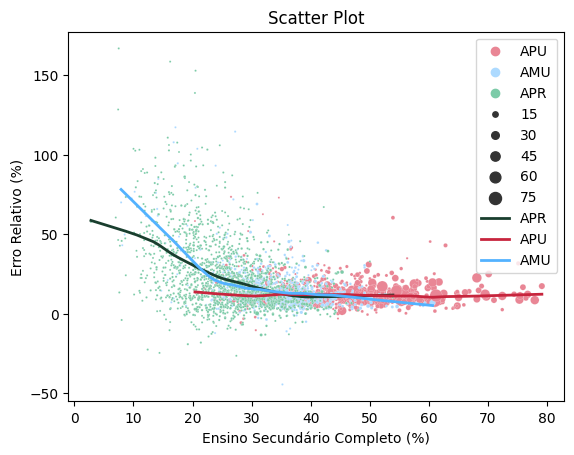

In [64]:
import pandas as pd
import seaborn as sns
from scipy.stats import sem
import matplotlib.pyplot as plt

# Group the data and calculate conditional means
grouped_data_APR = comp_APR.groupby('sec+_INE_21')['diff_rel_21'].mean().reset_index()
grouped_data_APU = comp_APU.groupby('sec+_INE_21')['diff_rel_21'].mean().reset_index()
grouped_data_AMU = comp_AMU.groupby('sec+_INE_21')['diff_rel_21'].mean().reset_index()
# Apply LOESS smoothing to the grouped data
smoothed_data_APR = lowess(grouped_data_APR['diff_rel_21'], grouped_data_APR['sec+_INE_21'], frac=0.3)
smoothed_data_APU = lowess(grouped_data_APU['diff_rel_21'], grouped_data_APU['sec+_INE_21'], frac=0.3)
smoothed_data_AMU = lowess(grouped_data_AMU['diff_rel_21'], grouped_data_AMU['sec+_INE_21'], frac=0.3)

scaler = MinMaxScaler(feature_range=(1, 40))  # Adjust the feature range as needed
pt_ine_21_scaled = scaler.fit_transform(comp['PT_INE_21'].values.reshape(-1, 1)).flatten()*2

# Set up the scatter plot
fig, ax = plt.subplots()
sns.scatterplot(data=comp, x='sec+_INE_21', y='diff_rel_21', hue='TIPAU', palette=cmap_grey, size=pt_ine_21_scaled, sizes=(2, 80), ax=ax)
ax.set_xlabel('Ensino Secundário Completo (%)')
ax.set_ylabel('Erro Relativo (%)')
ax.set_title('Scatter Plot')

# Add the smoothed line
sns.lineplot(x=grouped_data_APR['sec+_INE_21'], y=smoothed_data_APR[:, 1], ax=ax, color='#193E2E', label='APR', linewidth=2)
sns.lineplot(x=grouped_data_APU['sec+_INE_21'], y=smoothed_data_APU[:, 1], ax=ax, color='#C7253D', label='APU', linewidth=2)
sns.lineplot(x=grouped_data_AMU['sec+_INE_21'], y=smoothed_data_AMU[:, 1], ax=ax, color='#53B2FF', label='AMU', linewidth=2)

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(5, 6))

ax1 = plt.subplot(2, 1, 1)
plt.scatter(comp['desemprego_INE_21'], comp['diff_rel_21'], c=comp['TIPAU'].map(cmap), s=2)

plt.ylabel('Erro Relativo (%)')

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.scatter(comp_1000['desemprego_INE_21'], comp_1000['diff_rel_21'], c=comp_1000["TIPAU"].map(cmap), s=2)
plt.xlabel('Desemprego (%)')
plt.ylabel('Erro Relativo (%)\n >1000 habitantes')

plt.suptitle('')


plt.show()


In [ ]:
fig = px.scatter(comp_APU, x='desemprego_INE_21', y='diff_rel_21',
                                  labels={
                     "diff_rel_21": "Erro Relativo (%)",
                     "desemprego_INE_21": "Desemprego (%)"
                 }, color='TIPAU', color_discrete_map=cmap, hover_data=['FF_DSG', "PT_INE_21", "PT_MAI_21"])

# Show the plot
fig.show()

In [ ]:
fig = px.scatter(comp_APU, x='65+_INE_21', y='diff_rel_21',
                                  labels={
                     "diff_rel_21": "Erro Relativo (%)",
                     "desemprego_INE_21": "Desemprego (%)"
                 }, color='TIPAU', color_discrete_map=cmap, hover_data=['FF_DSG', "PT_INE_21", "PT_MAI_21"])

# Show the plot
fig.show()

In [ ]:
plt.figure(figsize=(5, 6))

ax1 = plt.subplot(2, 1, 1)
plt.scatter(comp['65+_INE_21'], comp['diff_rel_21'], c=comp['TIPAU'].map(cmap), s=2)

plt.ylabel('Erro Relativo (%)')

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.scatter(comp_1000['65+_INE_21'], comp_1000['diff_rel_21'], c=comp_1000["TIPAU"].map(cmap), s=2)
plt.xlabel('+65 (%)')
plt.ylabel('Erro Relativo (%)\n >1000 habitantes')

plt.suptitle('')


plt.show()


In [ ]:
comp.columns

In [ ]:
plt.figure(figsize=(5, 6))

ax1 = plt.subplot(2, 1, 1)
plt.scatter(comp['VAR_PT_21_11_rel'], comp['diff_rel_21'], c=comp['TIPAU'].map(cmap), s=2)

plt.ylabel('Erro Relativo (%)')

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.scatter(comp_1000['VAR_PT_21_11_rel'], comp_1000['diff_rel_21'], c=comp_1000["TIPAU"].map(cmap), s=2)
plt.xlabel('Variação População (2011-2021) (%)')
plt.ylabel('Erro Relativo (%)\n >1000 habitantes')

plt.suptitle('')


plt.show()


In [ ]:
fig = px.scatter(comp_APU, x='VAR_PT_21_11_rel', y='diff_rel_21',
                                  labels={
                     "diff_rel_21": "Erro Relativo (%)",
                     "VAR_PT_21_11_rel": "Variação População (2011-2021) (%)"
                 }, color='TIPAU', color_discrete_map=cmap, hover_data=["CC_DSG",'FF_DSG', "PT_INE_21", "PT_MAI_21", "PT_INE_11", "PT_MAI_11"])

# Show the plot
fig.show()

In [ ]:
fig = px.scatter(comp_1000, x='diff_rel_11', y='diff_rel_21',
                                  labels={
                     "diff_rel_21": "Erro Relativo 2021 (%)",
                     "diff_rel_11": "Erro Relativo 2011 (%)"
                 }, color='TIPAU', color_discrete_map=cmap, hover_data=["CC_DSG",'FF_DSG', "PT_INE_21", "PT_MAI_21", "PT_INE_11", "PT_MAI_11"])

fig.add_shape(type="line",
              x0=-15, 
              y0=-15, 
              x1=70, 
              y1=70)
# Show the plot
fig.show()

In [ ]:
comp_1000.sort_values(by="diff_rel_21", ascending=False)

In [ ]:
populacao.sort_values(by="sec+_INE_21", ascending=False)

In [ ]:
sns.scatterplot(data=comp, x="secundari", y="diff_rel_21")

In [ ]:
district_stats1 = comp.groupby('Distrito')[var1].apply(lambda x: pd.Series({'weighted_mean_diff': (x * comp.loc[x.index, 'PT_INE_21']).sum() / comp.loc[x.index, 'PT_INE_21'].sum()}))
district_stats1 = pd.DataFrame(district_stats1).reset_index().drop(columns=["level_1"]).set_index("Distrito")
    

district_stats1 = comp.groupby('Distrito')[var1].apply(lambda x: pd.Series({'excesso_percentagem': x.sum() / comp[var1].sum() * 100}))
district_stats1 = pd.DataFrame(district_stats1).reset_index().drop(columns=["level_1"]).set_index("Distrito")

district_stats1.head()


In [ ]:
comp["diff_abs_21"].sum()

In [ ]:
district_stats.head()

In [ ]:
populacao[populacao["CC_DSG"] == "Lisboa"].tail(15)

In [ ]:
%pip install mplcursors